In [ ]:
from hill import *
import numpy as np
from scipy.integrate import quad

def epsilon(a, eps0, tau, t_e):
    return eps0 * np.exp(-(a - t_e) / tau)

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau):

    if a < t_e - delta:
        return hill_survival_function(a, mu_ub, mu_lb, K, m)
    
    elif t_e - delta <= a <= t_e:
        val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, delta-(t_e-a))
        return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)
    
    else:
        val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), a-t_e, a-t_e+delta)
        return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-epsilon(a, eps0, tau, t_e) * val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau) for a in ages])

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or delta < 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def fit_hill_with_dip(ages, survivors, totals, initial_guess = [0.1, 0.1, 7, 10, 8, 2.5, 3, 0.8]):
    from scipy.optimize import minimize

    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 8),      # delta
        (0.1, 30),    # eps0
        (0.01, 30)      # tau
    ]
    result = minimize(neg_ll_hill_with_dip, initial_guess, args=(ages, survivors, totals), bounds=bounds)

    return result

def lsq_hill_with_dip(params, ages, survival_fractions):
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = params
    model = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau)
    model = np.clip(model, 1e-12, 1 - 1e-12)
    return np.sum((survival_fractions - model) ** 2)

In [6]:
def find_dip(sector):
    from survival_analysis import obtain_survival_fractions, obtain_total_alive_count

    sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
    parameters = [
        [0.13660027, 0.03574423, 12.39113424, 4.14356328],
        [0.10877533, 0.0418096, 12.55269306, 4.41391222],
        [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
        [0.13090805, 0.03791174, 11.9429807, 4.05657508],
        [0.070120134, 0.011071032, 17.60063205, 11.71975389],
        [0.10301031, 0.04128293, 9.26045477, 8.13925264],
        [0.190143914, 0.028016019, 6.93767599, 100],
        [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
        [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
        [0.12568692, 0.03447114, 17.44283135, 5.60609428],
        [0.121213526, 0.068684245, 9.44518567, 100],
        [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
        [0.078301599, 0.047197935, 7.79197632, 100],
        [0.132289514, 0.085485775, 8.85732298, 100]
    ]
    sector_params_MLE = dict(zip(sector_list, parameters))

    _, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    mu_ub, mu_lb, K, m = sector_params_MLE[sector]
    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = survivors * np.log(S_vals) + deaths * np.log(1 - S_vals)

    minlogL_ages = ages[np.argsort(logL)[:9]]
    max_count = 0
    best_cluster = []

    for i in range(len(minlogL_ages)):
        # Find all points within window of minlogL_ages[i]
        cluster = minlogL_ages[(minlogL_ages >= minlogL_ages[i]) & (minlogL_ages <= minlogL_ages[i] + 0.5)]
        if len(cluster) > max_count:
            max_count = len(cluster)
            best_cluster = cluster

    return float(np.mean(best_cluster)) if len(best_cluster) > 0 else None

In [2]:
from survival_analysis import prepare_df
import pandas as pd

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


Fitted parameters (with dip):
mu_ub: 0.12, mu_lb: 0.06, K: 7.0, m: 5.0, t_e: 7.8, delta: 2.0, eps0: 4.0, tau: 0.8
AIC (with dip): 85306.72581456036


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


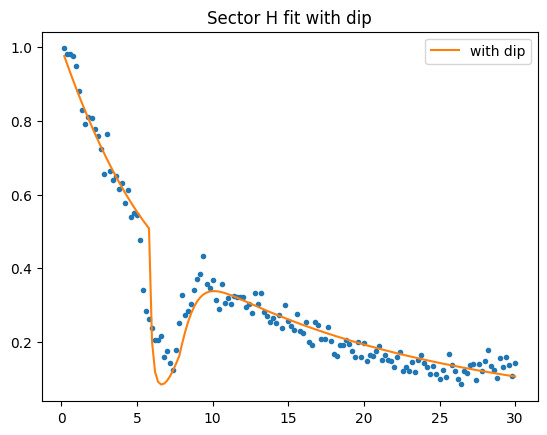

In [26]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'H')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'H')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.12, 0.06, 7, 5, 7.8, 2, 4, 0.8]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 10),       # t_e
    (0.1, 8),      # delta
    (0.1, 10),    # eps0
    (0.01, 10)      # tau
]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}")
aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f"AIC (with dip): {aic_with_dip}")

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector H fit with dip')
plt.legend()
plt.show()

# 83318

Fitted parameters (with dip):
mu_ub: 0.13, mu_lb: 0.05, K: 6.0, m: 10.0, t_e: 8.0, delta: 0.5, eps0: 8.0, tau: 0.4
AIC (with dip): 73673.63676684524


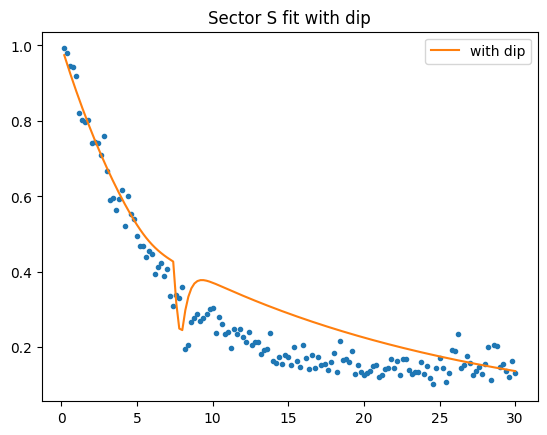

In [25]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'S')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'S')
from scipy.optimize import minimize

initial_guess = [0.13, 0.05, 6, 10, 8, 0.5, 8, 0.4]
bounds = [
    (0.01, 0.3),   # mu_ub
    (1e-6, 0.3),   # mu_lb
    (0.1, 30),     # K
    (0.5, 100),    # m
    (3, 15),       # t_e
    (0.1, 8),      # delta
    (0.01, 20),    # eps0
    (0.1, 30)      # tau
]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}")
aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f"AIC (with dip): {aic_with_dip}")

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.13660027, 0.03574423, 12.39113424, 4.14356328), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector S fit with dip')
plt.legend()
plt.show()

In [ ]:
print(f'mu_lb: {mu_lb}, mu_ub: {mu_ub}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

mu_lb: 1e-06, mu_ub: 0.13704259756217294, K: 13.290350822751982, m: 5.401760623468965, t_e: 8.384432962829331, delta: 0.38061318650338605, eps0: 8.833118154985302, tau: 0.23305975296383738


AIC for sector G
with dip: 395498.5259555067, original: 396775.65376669867
Parameters for sector G
mu_ub: 0.1303916582474728, mu_lb: 0.056678728060811166, K: 11.162389639130673, m: 10.025890556790792, t_e: 8.385575299935573, delta: 0.410200334548138, eps0: 10.065170271108508, tau: 0.3805347894509429


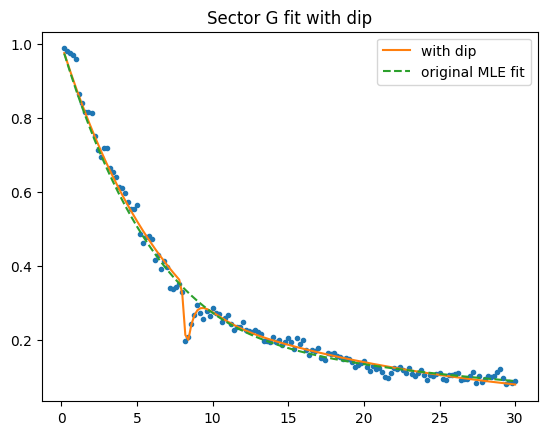

AIC for sector M
with dip: 213569.04374310983, original: 213844.85279567266
Parameters for sector M
mu_ub: 0.10647361404639208, mu_lb: 0.05585813645243449, K: 11.552731537084956, m: 10.034240197486314, t_e: 8.258993230830486, delta: 0.29378158189418613, eps0: 9.964551045731051, tau: 0.4884351478240139


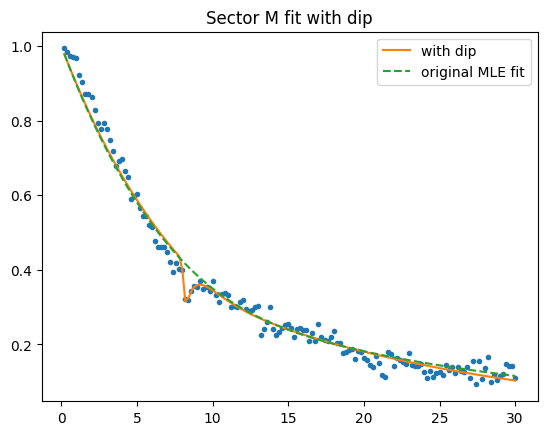

AIC for sector F
with dip: 95561.55351603252, original: 95543.98775340038
Parameters for sector F
mu_ub: 0.08394234536763127, mu_lb: 0.07353199928772076, K: 6.566869167667441, m: 10.201939708044868, t_e: 8.376041684556425, delta: 0.18919053902333466, eps0: 14.782779497645201, tau: 0.11681070118598887


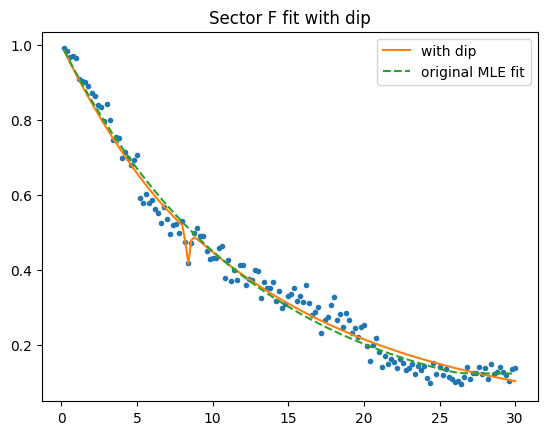

AIC for sector J
with dip: 113879.71537118118, original: 113998.28886457565
Parameters for sector J
mu_ub: 0.12995266983260453, mu_lb: 0.055619078799653374, K: 9.904370669699881, m: 9.881631279679214, t_e: 8.244435442339764, delta: 0.26599377643069705, eps0: 9.914790832158683, tau: 0.29975198975145145


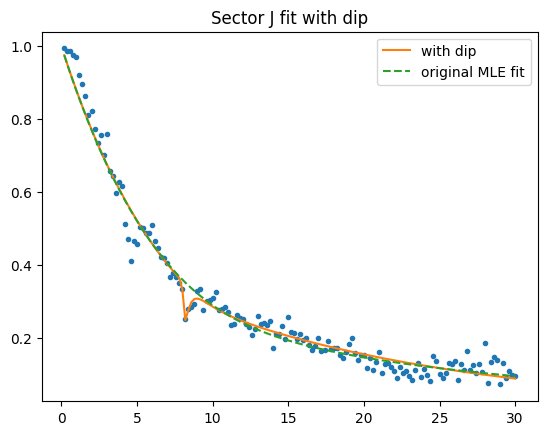

AIC for sector K
with dip: 112249.43387138483, original: 112433.7547568274
Parameters for sector K
mu_ub: 0.06500790876396928, mu_lb: 1e-06, K: 20.208815277998657, m: 6.741112112389976, t_e: 6.503182153131284, delta: 0.10260008112082657, eps0: 16.28939478114283, tau: 30.0


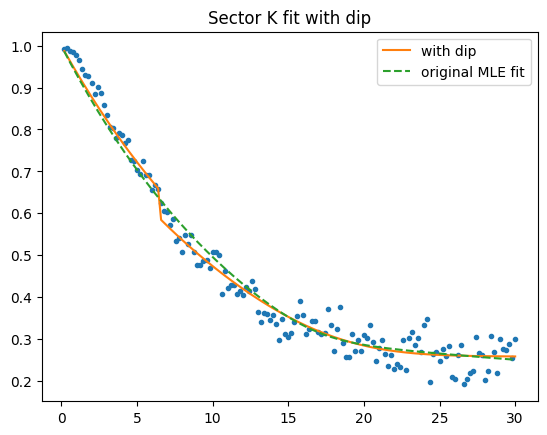

AIC for sector C
with dip: 79062.23934543521, original: 79121.45006331938
Parameters for sector C
mu_ub: 0.09989960295911582, mu_lb: 0.04816680202912991, K: 8.734347739815181, m: 10.031839146371938, t_e: 8.376594441583812, delta: 0.24558243779964, eps0: 9.984653527526238, tau: 0.1560694265081189


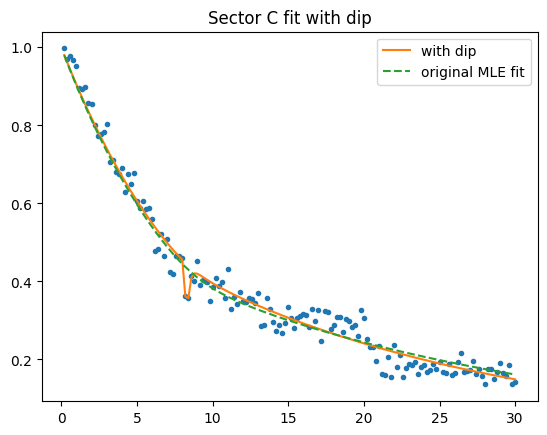

AIC for sector H
with dip: 83406.9062998275, original: 85957.7009922323
Parameters for sector H
mu_ub: 0.12230152968953943, mu_lb: 0.06750237392714042, K: 6.211985615162962, m: 10.65312808903855, t_e: 7.399992472193676, delta: 2.1755811449964857, eps0: 2.715151758842952, tau: 1.1369717573601748


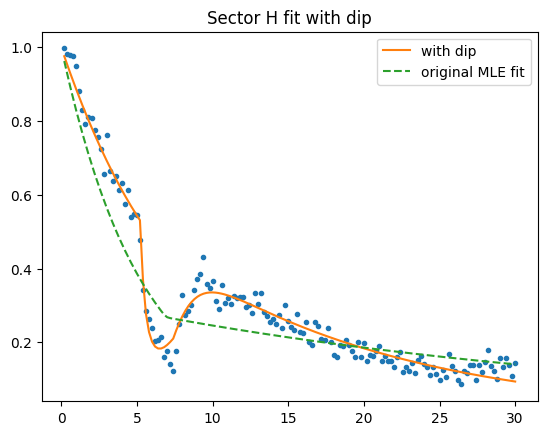

AIC for sector S
with dip: 71436.30631793785, original: 71512.5738700587
Parameters for sector S
mu_ub: 0.13892169318972622, mu_lb: 0.01935475649280554, K: 11.670776070466793, m: 9.907859947149198, t_e: 8.400949687551869, delta: 0.2009752744617954, eps0: 10.009637004041533, tau: 0.021046081287749978


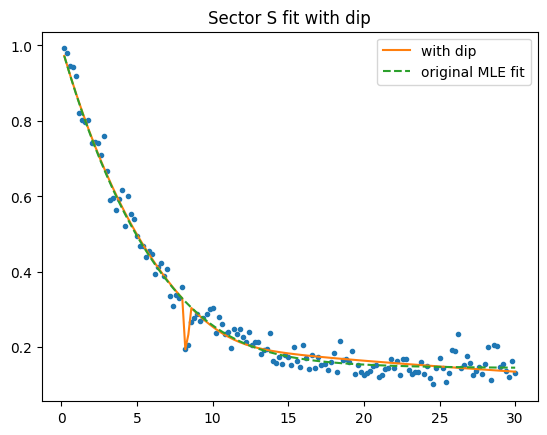

AIC for sector N
with dip: 73876.48911849303, original: 74032.64426437464
Parameters for sector N
mu_ub: 0.1195328174271293, mu_lb: 1e-06, K: 16.904507683678705, m: 4.329929006166933, t_e: 8.385063126080576, delta: 0.39865749679677875, eps0: 9.581253230214216, tau: 0.27801092014263307


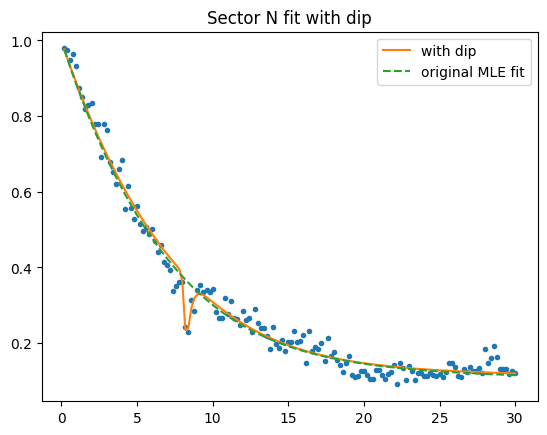

AIC for sector I
with dip: 68454.92198862741, original: 68509.00744804495
Parameters for sector I
mu_ub: 0.12507508841742299, mu_lb: 1e-06, K: 21.04800447603476, m: 4.176283233705438, t_e: 8.399999993132717, delta: 0.4095454186619659, eps0: 4.997813107754394, tau: 0.2412728326320533


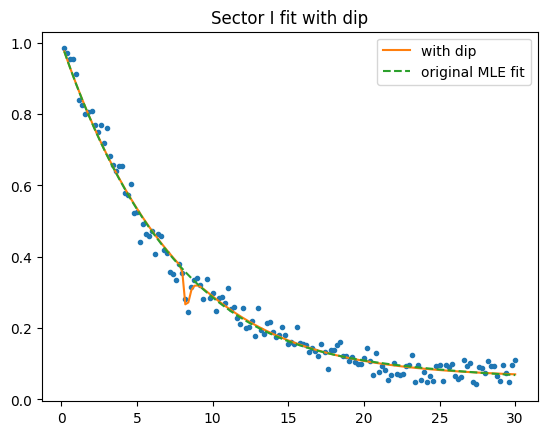

AIC for sector P
with dip: 50282.958553028715, original: 50319.80915016665
Parameters for sector P
mu_ub: 0.11802825748005058, mu_lb: 0.06893003023381246, K: 9.719985831170604, m: 100.0, t_e: 8.163770380083529, delta: 0.20681293280472837, eps0: 9.741119203602448, tau: 0.9998091409732782


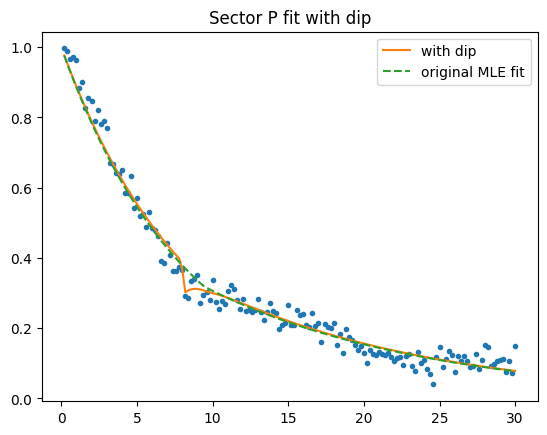

AIC for sector L
with dip: inf, original: 23846.6358313165
Parameters for sector L
mu_ub: 0.0741482164504634, mu_lb: 0.07506255299505123, K: 6.799191504133007, m: 9.99984170052715, t_e: 8.691340431839016, delta: 0.10390985708069082, eps0: 9.828422914642477, tau: 0.21137931799979692


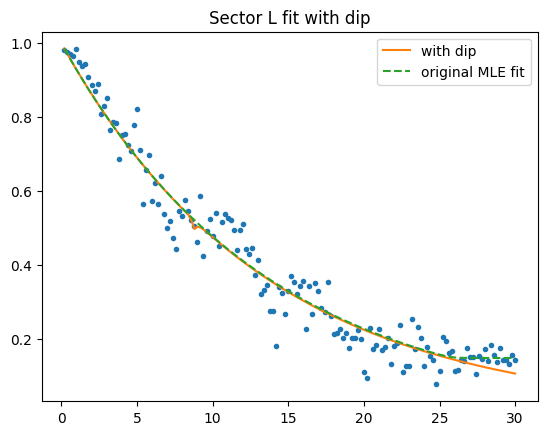

AIC for sector Q
with dip: 25778.71931120603, original: 25785.161680934158
Parameters for sector Q
mu_ub: 0.07815059126931538, mu_lb: 0.04937641231714568, K: 6.905354083066287, m: 10.026195218262844, t_e: 8.438807120294188, delta: 0.3092489025983063, eps0: 9.91116592250179, tau: 0.34885240911666354


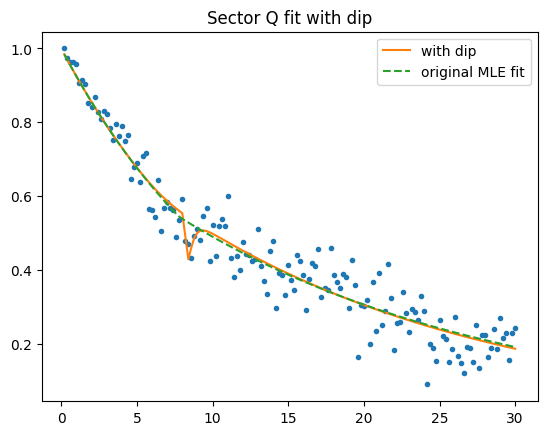

AIC for sector R
with dip: 15043.12125502431, original: 15047.29190362784
Parameters for sector R
mu_ub: 0.12968116032150304, mu_lb: 0.09021736516497657, K: 7.600700459137173, m: 10.169512660047161, t_e: 7.822012586817117, delta: 0.17512057690020824, eps0: 9.943051293181576, tau: 2.6407553643895243


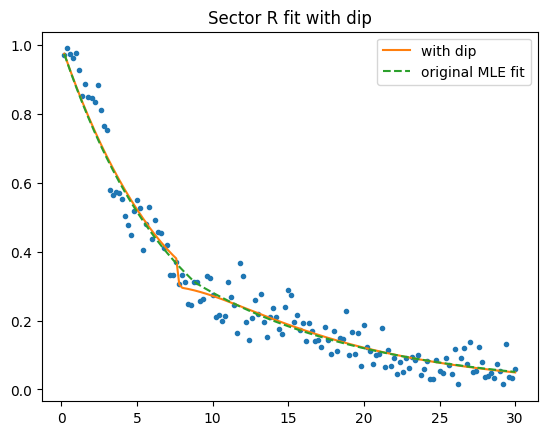

In [27]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess1, initial_guess2 = [0.13, 0.05, 9, 10, 8, 0.3, 10, 0.4], [0.12, 0.06, 7, 10, 8, 2.5, 10.0, 1.0]
    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.3),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 8),      # delta
        (0.1, 20),    # eps0
        (0.01, 30)      # tau
    ]

    result1 = minimize(lsq_hill_with_dip, initial_guess1, args=(ages, survival_fractions), bounds=bounds)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    result2 = minimize(lsq_hill_with_dip, initial_guess2, args=(ages, survival_fractions), bounds=bounds)
    ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x

    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

C:\Users\chong\AppData\Local\Temp\ipykernel_23156\637973434.py:6: RuntimeWarning: overflow encountered in exp
  return eps0 * np.exp(-(a - t_e) / tau)


AIC for sector G
with dip: 395490.57956823945, original: 396775.65376669867
Parameters for sector G
mu_ub: 0.1295208545944822, mu_lb: 0.04932689302688402, K: 12.073981131177867, m: 6.409731727273707, t_e: 8.459949705972774, delta: 0.48449756135396643, eps0: 8.118896571931247, tau: 0.3357411466859521


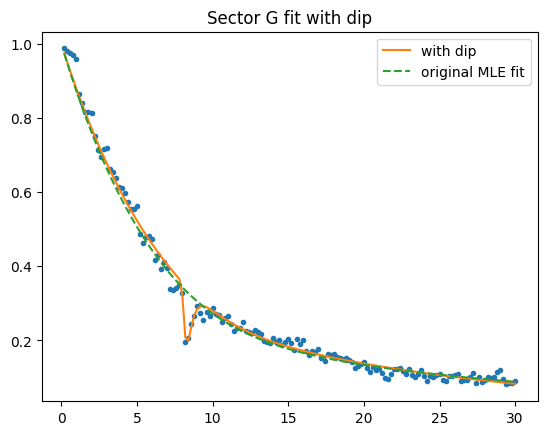

AIC for sector M
with dip: 213526.56286359055, original: 213844.85279567266
Parameters for sector M
mu_ub: 0.10021143044883066, mu_lb: 0.05255945207135979, K: 13.679584997447442, m: 6.477503477159019, t_e: 7.1388629530508405, delta: 0.2530734258886624, eps0: 8.79911019602141, tau: 3.0556053020617324


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


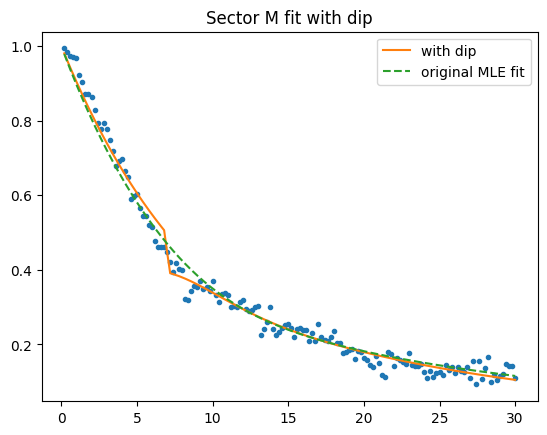

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector F
with dip: 95619.64152749779, original: 95543.98775340038
Parameters for sector F
mu_ub: 0.08157815964660757, mu_lb: 0.07622698691596508, K: 6.582519188381165, m: 3.1762229835730866, t_e: 9.167464462246334, delta: 0.3034926811637974, eps0: 4.798161023563374, tau: 0.18394946145792715


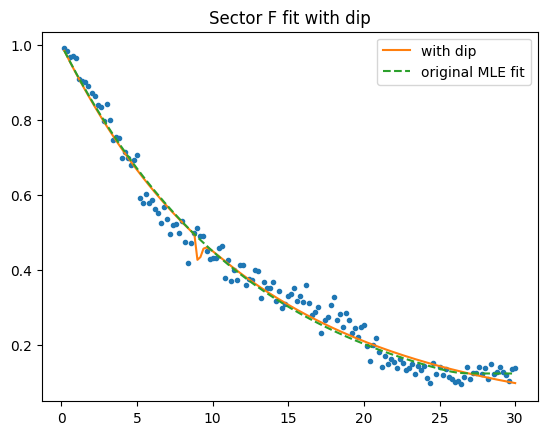

AIC for sector J
with dip: 113688.65630000373, original: 113998.28886457565
Parameters for sector J
mu_ub: 0.1251443676038105, mu_lb: 0.0597102793533107, K: 10.519288803949337, m: 16.129986407748344, t_e: 4.676423530526261, delta: 0.3967253619158897, eps0: 5.818406915308948, tau: 0.3179015437481666


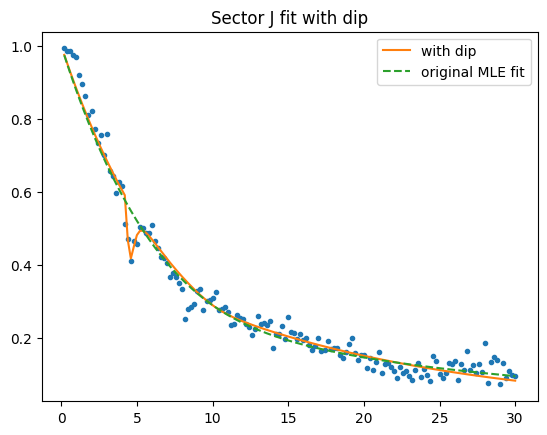

AIC for sector K
with dip: 112362.7342084381, original: 112433.7547568274
Parameters for sector K
mu_ub: 0.06678266950436024, mu_lb: 0.03964333541978973, K: 13.778894796753264, m: 6.102084116611046, t_e: 7.377191274776953, delta: 0.3480330473968716, eps0: 5.0639503003239605, tau: 12.64988636507157


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


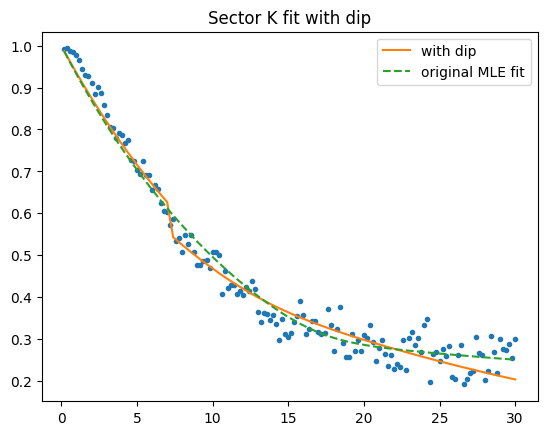

AIC for sector C
with dip: 79056.26704588314, original: 79121.45006331938
Parameters for sector C
mu_ub: 0.0950024544438413, mu_lb: 0.0521613495253965, K: 7.818503060486506, m: 67.07609510388741, t_e: 7.16186377566214, delta: 0.2195720492634523, eps0: 5.134209502900033, tau: 30.0


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


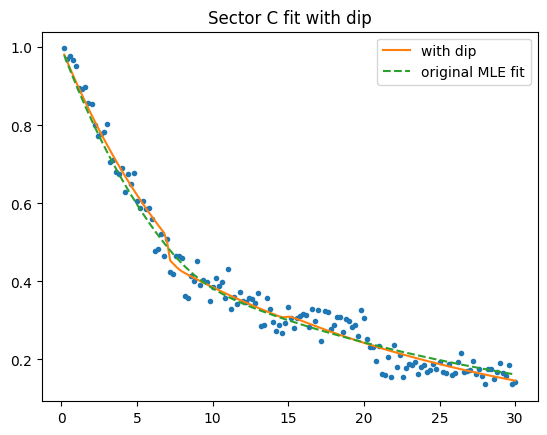

AIC for sector H
with dip: 83306.89145241212, original: 85957.7009922323
Parameters for sector H
mu_ub: 0.12101373063135187, mu_lb: 0.026885550572725195, K: 12.67062839109172, m: 1.258499781279579, t_e: 7.399991514661023, delta: 2.2652434572588214, eps0: 3.4554744371999404, tau: 1.5135079572673504


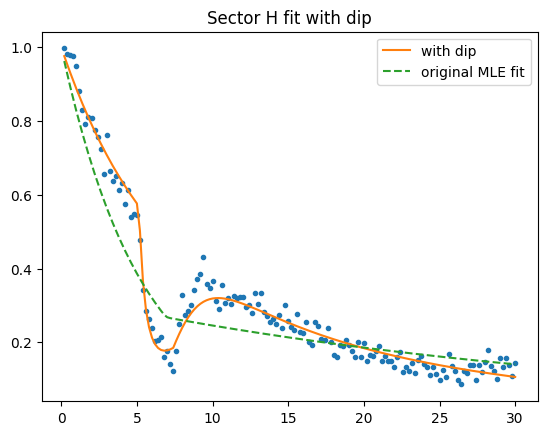

AIC for sector S
with dip: 71386.99077959372, original: 71512.5738700587
Parameters for sector S
mu_ub: 0.13582600236987324, mu_lb: 1e-06, K: 13.633346376716577, m: 4.858770241473908, t_e: 8.41217503405052, delta: 0.4121748142724853, eps0: 8.09527112488922, tau: 0.23920516036633171


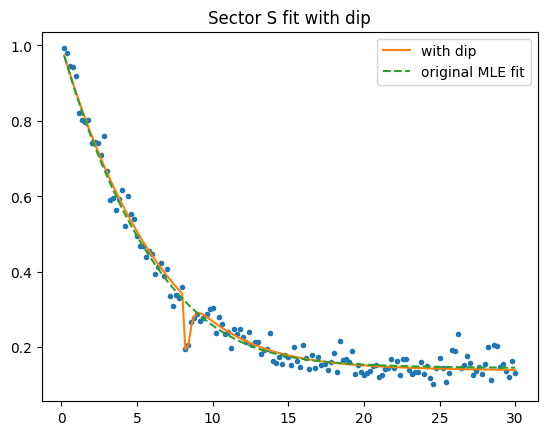

AIC for sector N
with dip: 73880.12626994155, original: 74032.64426437464
Parameters for sector N
mu_ub: 0.11589423699777326, mu_lb: 1e-06, K: 17.595370384984346, m: 6.366919311844867, t_e: 8.366160177295388, delta: 0.3850031190298657, eps0: 11.579007110988695, tau: 0.31296509010137397


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


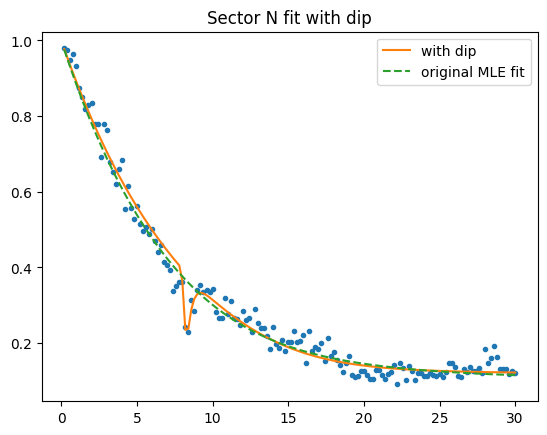

AIC for sector I
with dip: 68838.04553246702, original: 68509.00744804495
Parameters for sector I
mu_ub: 0.13, mu_lb: 0.06, K: 11.0, m: 5.0, t_e: 5.6000000000000005, delta: 0.45, eps0: 8.0, tau: 0.3


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


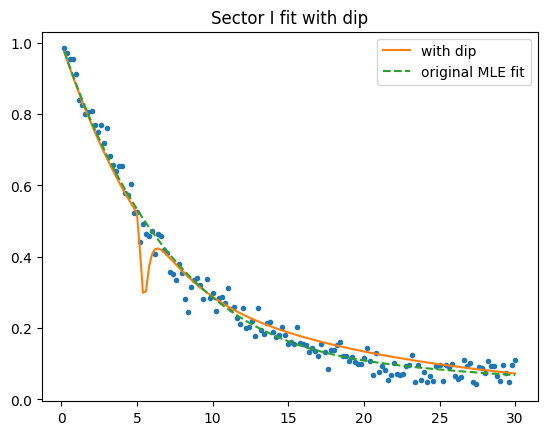

AIC for sector P
with dip: 50288.05137548568, original: 50319.80915016665
Parameters for sector P
mu_ub: 0.1161059926153968, mu_lb: 0.06631127023204952, K: 10.542573314728468, m: 4.8219345677006995, t_e: 8.199999931943733, delta: 0.29451224449991614, eps0: 7.660736834889863, tau: 1.5025957577442888


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


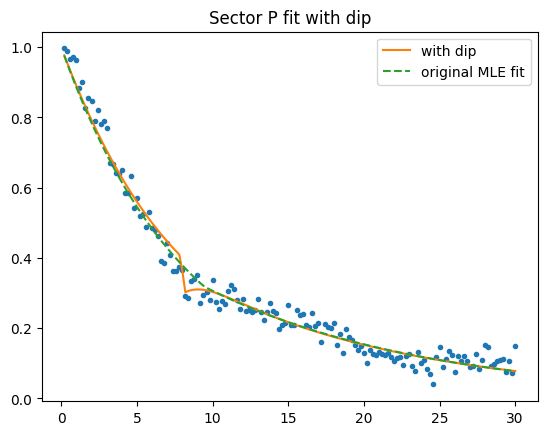

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector L
with dip: 23884.90560718203, original: 23846.6358313165
Parameters for sector L
mu_ub: 0.07543101275335322, mu_lb: 0.06782109241266676, K: 7.24545722291755, m: 3.4498783110474487, t_e: 9.605251658964516, delta: 0.3290951309782155, eps0: 5.2787667611872795, tau: 0.20004582485449604


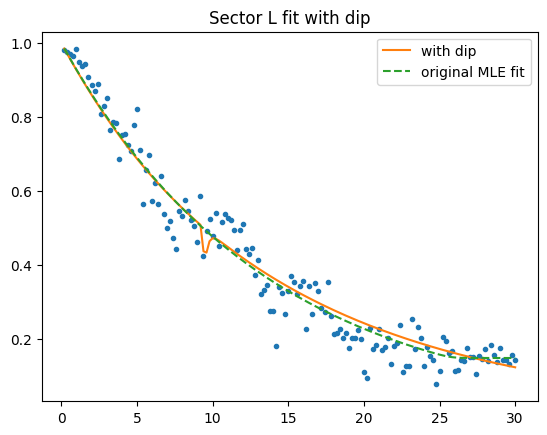

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector Q
with dip: 25775.422898189587, original: 25785.161680934158
Parameters for sector Q
mu_ub: 0.0717782854867687, mu_lb: 0.05230910638548808, K: 6.384912398213594, m: 9.995699053955148, t_e: 6.249410035875573, delta: 1.1296311348495696, eps0: 1.5090593472757834, tau: 6.2571516928715205


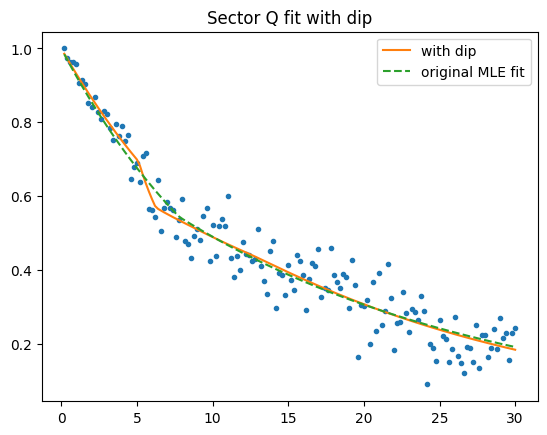

AIC for sector R
with dip: 15117.806724081784, original: 15047.29190362784
Parameters for sector R
mu_ub: 0.13, mu_lb: 0.06, K: 11.0, m: 5.0, t_e: 3.5999999999999996, delta: 0.45, eps0: 8.0, tau: 0.3


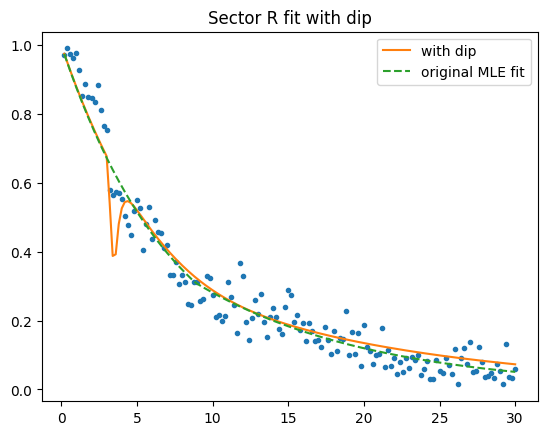

In [57]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess1, initial_guess2 = [0.13, 0.06, 11, 5, find_dip(sector), 0.45, 8, 0.3], [0.13, 0.1, 7, 10, find_dip(sector), 2.5, 4, 1]
    bounds = [
        (0.01, 0.3),   # mu_ub
        (1e-6, 0.15),   # mu_lb
        (0.1, 30),     # K
        (0.5, 100),    # m
        (3, 10),       # t_e
        (0.1, 4),      # delta
        (0.1, 20),    # eps0
        (0.01, 30)      # tau
    ]

    result1 = fit_hill_with_dip(ages, survivors, totals, initial_guess1)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    result2 = fit_hill_with_dip(ages, survivors, totals, initial_guess2)
    ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, delta, eps0, tau = result.x

    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, delta: {delta}, eps0: {eps0}, tau: {tau}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, delta, eps0, tau), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

WITHOUT DELTA

In [47]:
from hill import *
import numpy as np
from scipy.integrate import quad

def epsilon(s, a, eps0, tau, lam, t_e):
    def g(a, eps0, tau, t_e):
        return eps0 * np.exp(-abs(a - t_e) * tau)
    if s < a - t_e:
        return 0
    else:
        return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)
    return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam) for a in ages])

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or eps0 < 0 or tau <= 0 or lam <= 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def fit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 6, 10, 5, 1, 1, 1]):
    from scipy.optimize import minimize

    bounds = [
        (0.01, 0.3),   # mu_ub
        (0.01, 0.15),   # mu_lb
        (0.1, 30),     # K
        (0.5, 50),    # m
        (3, 10),      # t_e
        (0, 20),    # eps0
        (0.01, 10),      # tau
        (0.001, 10)      # lam
    ]

    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # mu_ub - mu_lb > 0
        {'type': 'ineq', 'fun': lambda x: x[6] - x[7]},  # tau - lam > 0
    ]

    result = minimize(
        neg_ll_hill_with_dip,
        initial_guess,
        args=(ages, survivors, totals),
        bounds=bounds,
        constraints=constraints
    )

    return result

def lsq_hill_with_dip(params, ages, survival_fractions):
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = params
    model = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam)
    model = np.clip(model, 1e-12, 1 - 1e-12)
    return np.sum((survival_fractions - model) ** 2)

Fitted parameters (with dip):
mu_ub: 0.12635762803631076, mu_lb: 0.04925584174885047, K: 12.640443158552493, m: 6.812588502729498, t_e: 8.28305011526302, eps0: 3.5621017839361704, tau: 1.585329148810721, lam: 0.775946450470156
AIC = 395474.67157937895


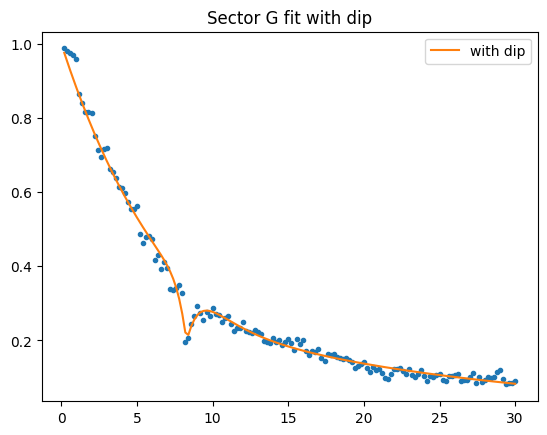

In [ ]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'G')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'G')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.13, 0.06, 10, 5, 8.2, 3, 2, 0.65]
# bounds = [
#     (0.01, 0.3),   # mu_ub
#     (0.01, 0.15),   # mu_lb
#     (0.1, 30),     # K
#     (0.5, 100),    # m
#     (3, 10),       # t_e
#     (0, 20),    # eps0
#     (0.01, 30)      # tau
# ]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f'AIC = {aic_with_dip}')

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector G fit with dip')
plt.legend()
plt.show()

C:\Users\chong\AppData\Local\Temp\ipykernel_19876\2135093956.py:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.09864655744980662, mu_lb: 0.010000003726624383, K: 23.726183904974512, m: 2.294429506324458, t_e: 6.879058195748627, eps0: 2.1530078281149465, tau: 0.674743595513634, lam: 0.001
AIC = 83388.49644552454


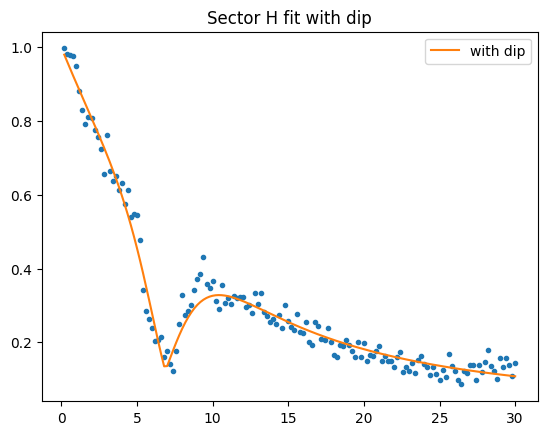

In [48]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'H')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'H')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.1, 0.05, 10, 5, find_dip('H'), 3, 0.7, 0.1]
# bounds = [
#     (0.01, 0.3),   # mu_ub
#     (0.01, 0.15),   # mu_lb
#     (0.1, 30),     # K
#     (0.5, 100),    # m
#     (3, 10),       # t_e
#     (0, 20),    # eps0
#     (0.01, 30)      # tau
# ]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f'AIC = {aic_with_dip}')

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector H fit with dip')
plt.legend()
plt.show()

# Fitted parameters (with dip):
# mu_ub: 0.11555052725787383, mu_lb: 0.06802543565439674, K: 6.28151448827344, m: 9.857046612774358, t_e: 7.399999994978641, delta: 2.258860201858482, eps0: 3.4390450728837187, tau: 1.5014303322016382
# AIC (with dip): 83317.78278673897

AIC for sector G
with dip: 395694.4493774432, original: 396775.65376669867
Parameters for sector G
mu_ub: 0.12896896525812326, mu_lb: 0.06543537179255131, K: 9.633639980764693, m: 5.077499986810655, t_e: 8.199999990594955, eps0: 2.5039578085048078, tau: 1.3852378380775874, lam: 0.6795224092232052


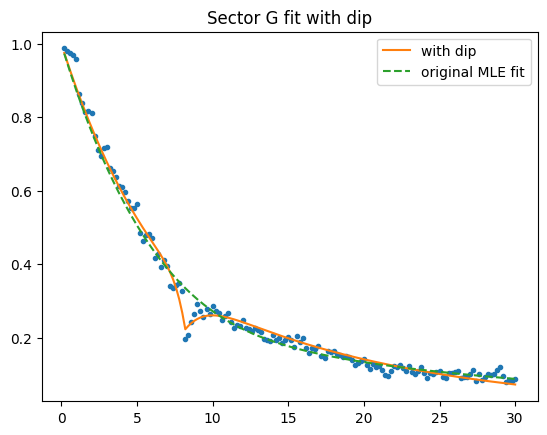

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector M
with dip: 213251.29598300136, original: 213844.85279567266
Parameters for sector M
mu_ub: 0.09116445031902905, mu_lb: 0.024574634400970557, K: 21.27889381080623, m: 6.351139342971191, t_e: 8.37625575155156, eps0: 0.4339895066140978, tau: 0.3463111963173321, lam: 0.01


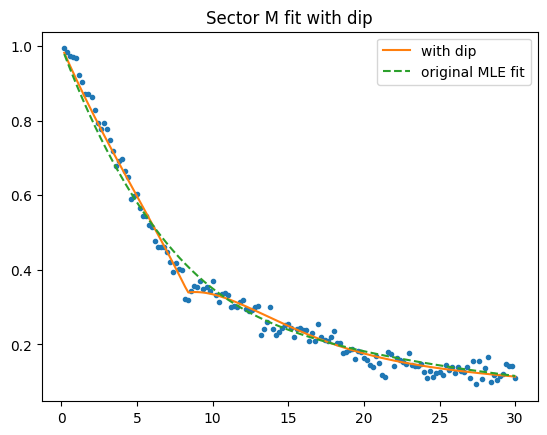

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector F
with dip: 97946.72186731179, original: 95543.98775340038
Parameters for sector F
mu_ub: 0.1, mu_lb: 0.05, K: 10.0, m: 5.0, t_e: 8.600000000000001, eps0: 3.0, tau: 1.0, lam: 0.5


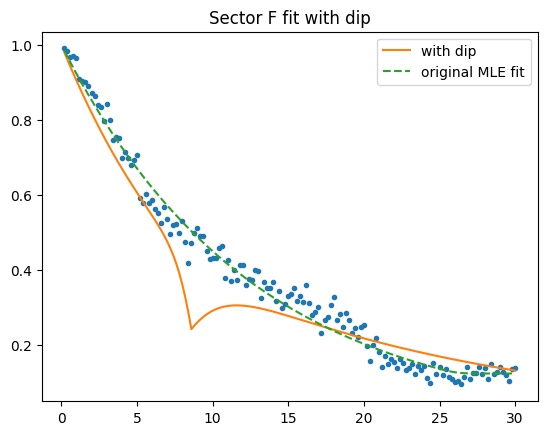

AIC for sector J
with dip: 113545.69687937658, original: 113998.28886457565
Parameters for sector J
mu_ub: 0.09236806548478078, mu_lb: 0.07285081792785345, K: 10.150882045776893, m: 5.0865201104849485, t_e: 4.468496494908776, eps0: 2.9196096033249654, tau: 0.7653045202412154, lam: 0.723032298451908


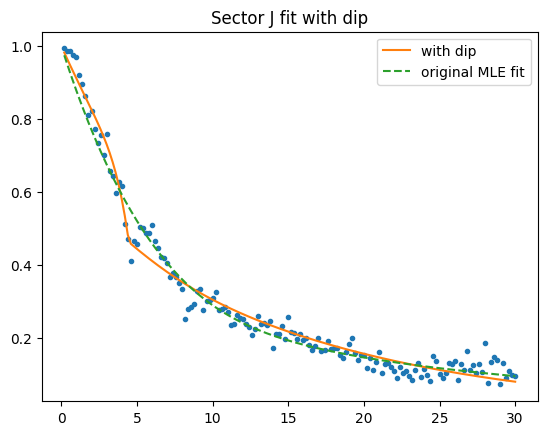

AIC for sector K
with dip: 119072.99187936453, original: 112433.7547568274
Parameters for sector K
mu_ub: 0.1, mu_lb: 0.05, K: 10.0, m: 5.0, t_e: 10.0, eps0: 3.0, tau: 1.0, lam: 0.5


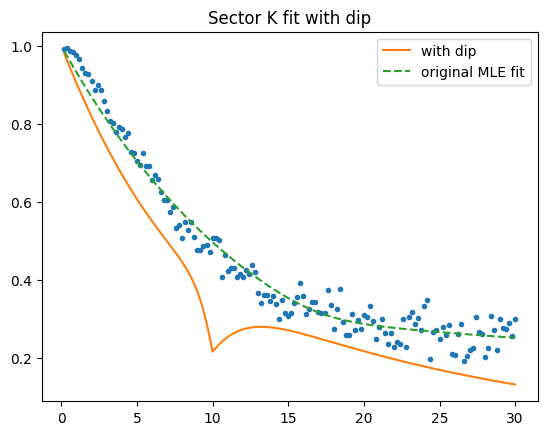

AIC for sector C
with dip: 79721.0201918951, original: 79121.45006331938
Parameters for sector C
mu_ub: 0.1, mu_lb: 0.05, K: 10.0, m: 5.0, t_e: 8.600000000000001, eps0: 3.0, tau: 1.0, lam: 0.5


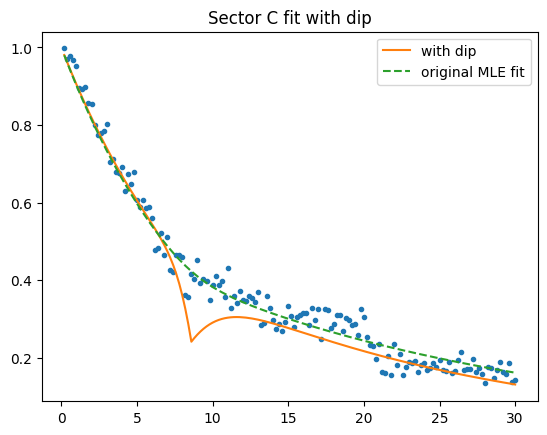

AIC for sector H
with dip: 83614.6420539217, original: 85957.7009922323
Parameters for sector H
mu_ub: 0.09575431245465166, mu_lb: 0.059974544350729526, K: 13.31047670322242, m: 9.087007450657238, t_e: 6.344876558958307, eps0: 5.815670186629964, tau: 0.8536149294502361, lam: 0.3538129560008418


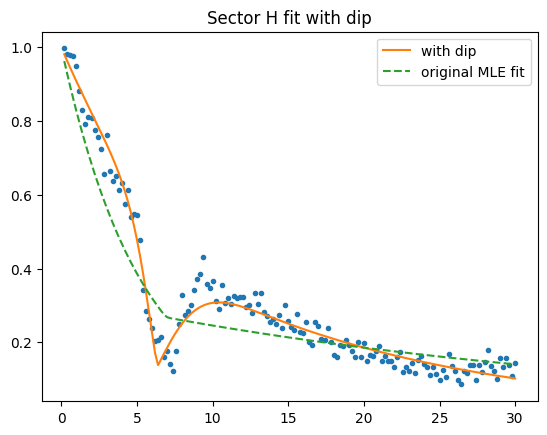

AIC for sector S
with dip: 71399.66598819873, original: 71512.5738700587
Parameters for sector S
mu_ub: 0.13639444059222594, mu_lb: 0.01, K: 12.83733749352539, m: 6.006912465583007, t_e: 8.295206488392749, eps0: 1.063140092483341, tau: 8.630352116364998, lam: 0.010226444921803149


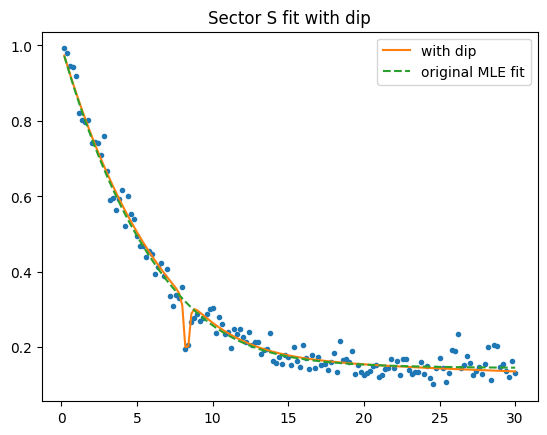

AIC for sector N
with dip: 73899.07213260964, original: 74032.64426437464
Parameters for sector N
mu_ub: 0.11893279254295766, mu_lb: 0.015433492212537968, K: 16.44131916596994, m: 3.781073142094267, t_e: 8.403846494798566, eps0: 2.174833050882657, tau: 3.930791300848872, lam: 0.4365840644223666


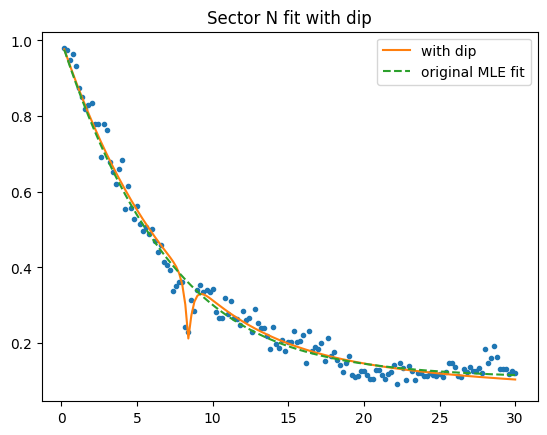

AIC for sector I
with dip: 68470.17061274078, original: 68509.00744804495
Parameters for sector I
mu_ub: 0.11520997107081629, mu_lb: 0.05958934446956447, K: 13.37325206556021, m: 4.116361208496052, t_e: 5.19999987466894, eps0: 1.0586318527159309, tau: 0.9119749445914542, lam: 0.9432831106844153


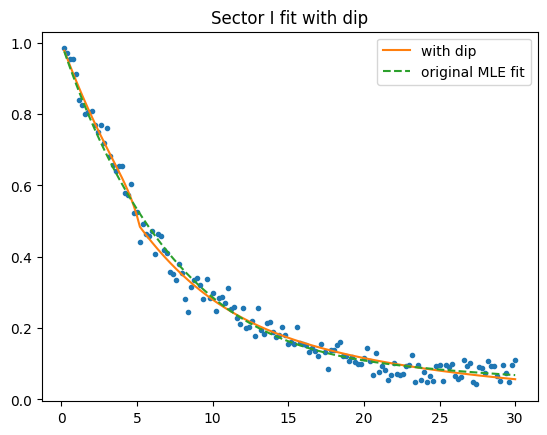

C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector P
with dip: 50246.73335051093, original: 50319.80915016665
Parameters for sector P
mu_ub: 0.10845185979854724, mu_lb: 0.07930963696910343, K: 10.343798163294004, m: 5.1551777808675, t_e: 7.995206972179743, eps0: 0.4235696123221167, tau: 0.46715379330247564, lam: 0.06314534242019018


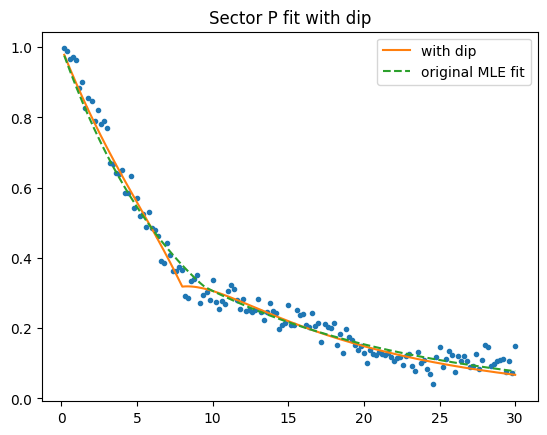

AIC for sector L
with dip: 24880.598445606724, original: 23846.6358313165
Parameters for sector L
mu_ub: 0.1, mu_lb: 0.05, K: 10.0, m: 5.0, t_e: 10.0, eps0: 3.0, tau: 1.0, lam: 0.5


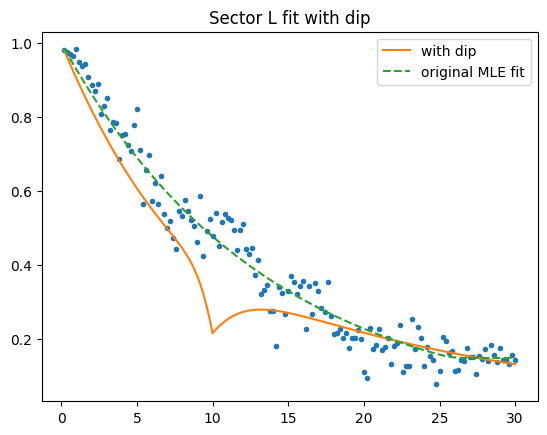

AIC for sector Q
with dip: 27223.606368155, original: 25785.161680934158
Parameters for sector Q
mu_ub: 0.1, mu_lb: 0.05, K: 10.0, m: 5.0, t_e: 8.6, eps0: 3.0, tau: 1.0, lam: 0.5


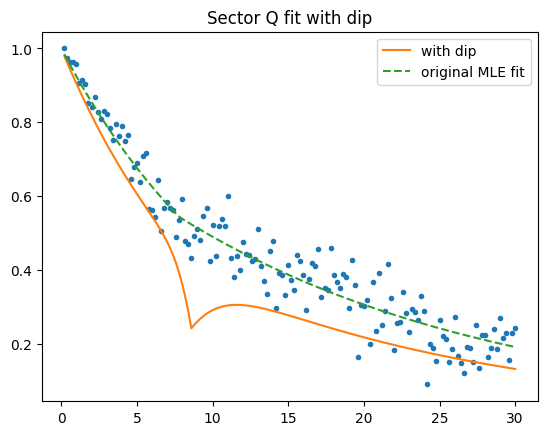

AIC for sector R
with dip: 14983.41675792733, original: 15047.29190362784
Parameters for sector R
mu_ub: 0.0863892707330576, mu_lb: 0.035425011004385935, K: 10.566099007948162, m: 5.022577547596528, t_e: 3.6593158816865947, eps0: 2.943705936866141, tau: 0.7804049111755511, lam: 0.844743156528581


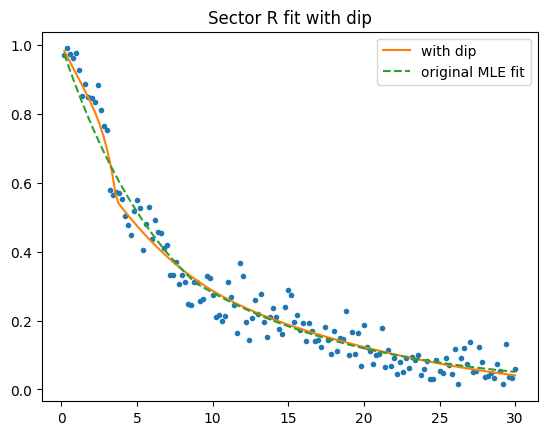

In [35]:
from scipy.optimize import minimize

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    # initial_guess1, initial_guess2 = [0.1, 0.05, 10, 5, find_dip(sector), 0.5, 0.3], [0.11, 0.08, 10, 5, find_dip(sector), 2.2, 0.7]
    initial_guess = [0.1, 0.05, 10, 5, find_dip(sector), 3, 1, 0.5]
    # bounds = [
    #     (0.01, 0.3),   # mu_ub
    #     (1e-6, 0.15),   # mu_lb
    #     (0.1, 30),     # K
    #     (0.5, 100),    # m
    #     (3, 10),       # t_e
    #     (0.1, 20),    # eps0
    #     (0.01, 30)      # tau
    # ]

    # result1 = minimize(lsq_hill_with_dip, initial_guess1, args=(ages, survival_fractions), bounds=bounds)
    result1 = fit_hill_with_dip(ages, survivors, totals, initial_guess)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    # result2 = minimize(lsq_hill_with_dip, initial_guess2, args=(ages, survival_fractions), bounds=bounds)
    # result2 = fit_hill_with_dip(ages, survivors, totals, initial_guess2)
    # ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 # if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x

    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

Skewed tau

In [49]:
from hill import *
import numpy as np
from scipy.integrate import quad

def epsilon(s, a, eps0, tau1, tau2, lam, t_e):
    def g(a, eps0, tau1, tau2, t_e):
        if a < t_e:
            return eps0 * np.exp(-abs(a - t_e) * tau1)
        else:
            return eps0 * np.exp(-abs(a - t_e) * tau2)
    if s < a-t_e:
        return 0
    else:
        return g(a, eps0, tau1, tau2, t_e)*np.exp(-lam*(t_e-(a-s)))

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam):
    val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau1, tau2, lam, t_e), 0, a)
    return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam) for a in ages])

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or eps0 < 0 or tau1 <= 0 or tau2 <= 0 or lam <= 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def fit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 6, 10, 5, 1, 1, 1, 1]):
    from scipy.optimize import minimize

    bounds = [
        (0.01, 0.3),   # mu_ub
        (0.01, 0.15),   # mu_lb
        (0.1, 30),     # K
        (0.5, 50),    # m
        (3, 10),      # t_e
        (0, 20),    # eps0
        (0.01, 10),      # tau1
        (0.01, 10),      # tau2
        (0.001, 10)      # lam
    ]

    # Constraint: tau1 > lam and tau2 > lam
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # mu_ub - mu_lb > 0
        {'type': 'ineq', 'fun': lambda x: x[6] - x[8]},  # tau1 - lam > 0
        {'type': 'ineq', 'fun': lambda x: x[7] - x[8]},  # tau2 - lam > 0
    ]

    result = minimize(
        neg_ll_hill_with_dip,
        initial_guess,
        args=(ages, survivors, totals),
        bounds=bounds,
        constraints=constraints
    )

    return result

def lsq_hill_with_dip(params, ages, survival_fractions):
    mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2 = params
    model = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2)
    model = np.clip(model, 1e-12, 1 - 1e-12)
    return np.sum((survival_fractions - model) ** 2)

Fitted parameters (with dip):
mu_ub: 0.12860155938018675, mu_lb: 0.043441635840052395, K: 12.854720572419252, m: 4.976588927702169, t_e: 8.166594743541738, eps0: 2.7246820133647045, tau1: 9.334962639201366, tau2: 1.5104866644584143, lam: 0.5424179276469426
AIC = 395467.189510808


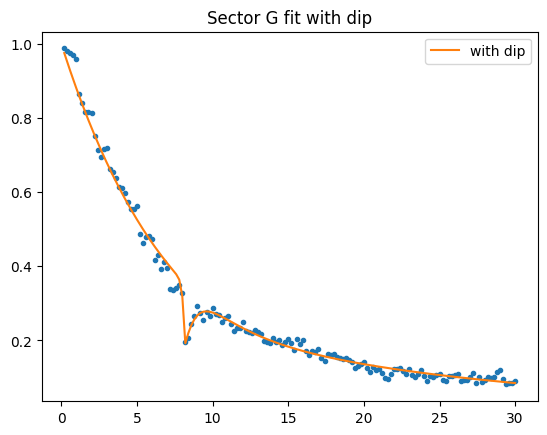

In [50]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'G')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'G')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.1, 0.05, 10, 5, 8.2, 1, 5, 2, 0.1]
# bounds = [
#     (0.01, 0.3),   # mu_ub
#     (0.01, 0.15),   # mu_lb
#     (0.1, 30),     # K
#     (0.5, 100),    # m
#     (3, 10),       # t_e
#     (0.1, 20),    # eps0
#     (0.01, 30)      # tau
# ]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau1: {tau1}, tau2: {tau2}, lam: {lam}")

aic_with_dip = 2 * 9 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f'AIC = {aic_with_dip}')

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector G fit with dip')
plt.legend()
plt.show()

# AIC for sector G
# with dip: 395498.34404120164, original: 396775.65376669867

Fitted parameters (with dip):
mu_ub: 0.09468133679609214, mu_lb: 0.010000000000000004, K: 21.564147254570965, m: 5.1886155921605654, t_e: 7.160295907807948, eps0: 2.5701938168112277, tau1: 0.47942290310402697, tau2: 1.0715002979303863, lam: 0.040356591384837256
AIC = 83288.19190933855


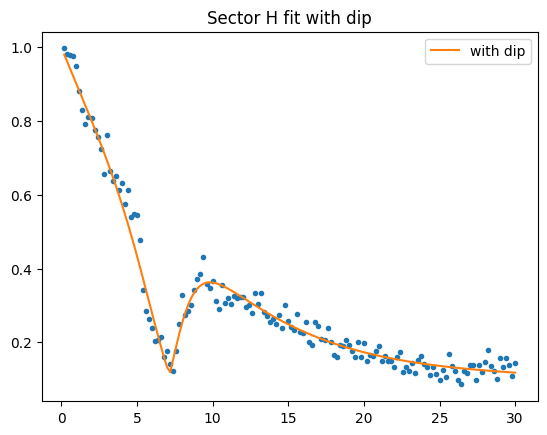

In [51]:
import matplotlib.pyplot as plt
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count
import numpy as np

survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', 'H')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'H')
# mu_lb, mu_ub, K, m, t_e, delta = fit_hill_with_dip(ages, survivors, totals, [0.18, 0.05, 6, 10, 7, 3]).x
from scipy.optimize import minimize

initial_guess = [0.1, 0.05, 10, 5, find_dip('H'), 3, 0.5, 1, 0.1]
# bounds = [
#     (0.01, 0.3),   # mu_ub
#     (0.01, 0.15),   # mu_lb
#     (0.1, 30),     # K
#     (0.5, 100),    # m
#     (3, 10),       # t_e
#     (0.1, 20),    # eps0
#     (0.01, 30)      # tau
# ]
# result = minimize(lsq_hill_with_dip, initial_guess, args=(ages, survival_fractions), bounds=bounds)
result = fit_hill_with_dip(ages, survivors, totals, initial_guess)
mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam = result.x
print("Fitted parameters (with dip):")
print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau1: {tau1}, tau2: {tau2}, lam: {lam}")

aic_with_dip = 2 * 9 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
print(f'AIC = {aic_with_dip}')

plt.plot(ages, survival_fractions, 'o', markersize=3)
plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2, lam), label='with dip')
# plt.plot(ages, model_survival_curve_hill(ages, 0.190143914, 0.028016019, 6.93767599, 100), '--', label = 'original MLE fit')
# plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
plt.title('Sector H fit with dip')
plt.legend()
plt.show()

AIC for sector G
with dip: 395459.5350294971, original: 396775.65376669867
Parameters for sector G
mu_ub: 0.12848994620748516, mu_lb: 0.043826291862109276, K: 12.8370529288786, m: 5.095975677134244, t_e: 8.217575808520335, eps0: 0.618208317087899, tau1: 0.15247732080880205, tau2: 0.557511526724038


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


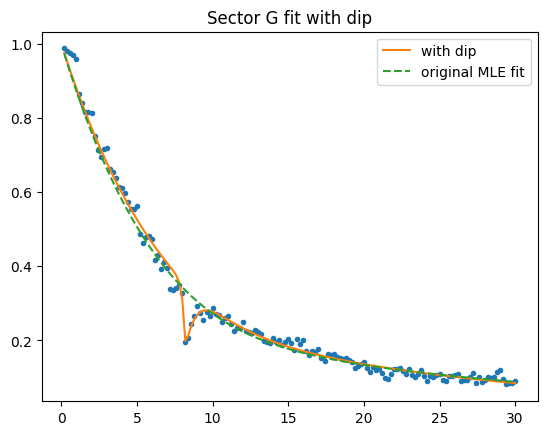

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector M
with dip: 213426.4278513621, original: 213844.85279567266
Parameters for sector M
mu_ub: 0.08382590923907383, mu_lb: 0.08232857879343555, K: 12.100014577919797, m: 5.7640930232572325, t_e: 7.678386954359552, eps0: 0.5681405151225759, tau1: 3.8819730514456396, tau2: 3.3478190830051187


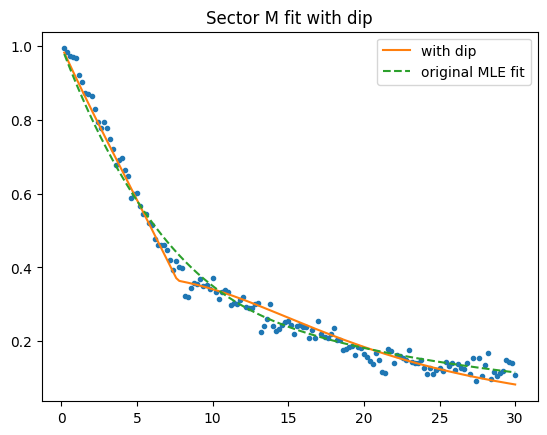

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector F
with dip: 96641.34490194015, original: 95543.98775340038
Parameters for sector F
mu_ub: 0.1, mu_lb: 0.05, K: 10.0, m: 5.0, t_e: 8.600000000000001, eps0: 0.5, tau1: 0.7, tau2: 0.3


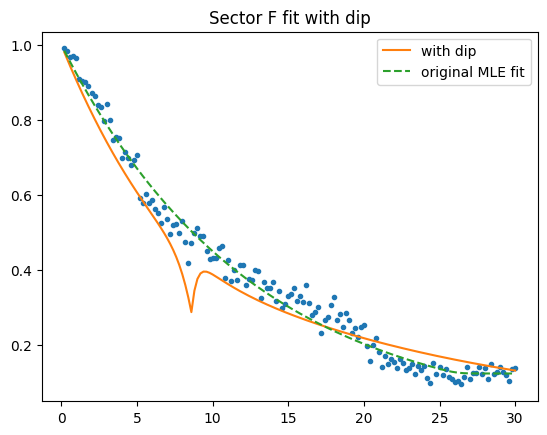

AIC for sector J
with dip: 113753.37520968738, original: 113998.28886457565
Parameters for sector J
mu_ub: 0.12556636065949767, mu_lb: 0.05178736608932654, K: 11.127974038408082, m: 6.041816786117732, t_e: 4.965759694915378, eps0: 0.8446505909553846, tau1: 0.4202478883748091, tau2: 0.029206651662162644


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


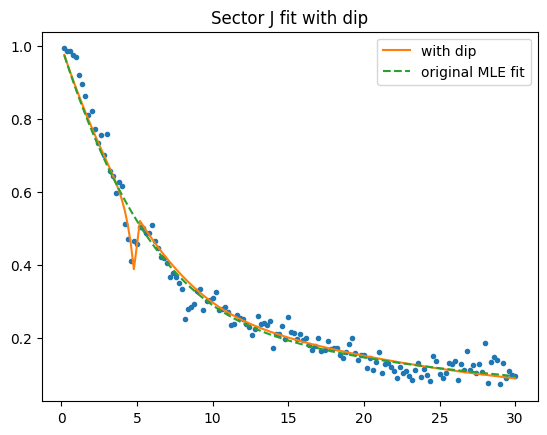

AIC for sector K
with dip: 112040.01111864485, original: 112433.7547568274
Parameters for sector K
mu_ub: 0.03088612548315715, mu_lb: 0.001, K: 26.73246051563885, m: 5.226465519838535, t_e: 7.343628999241081, eps0: 1.619220477010466, tau1: 5.216409836590389, tau2: 30.0


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


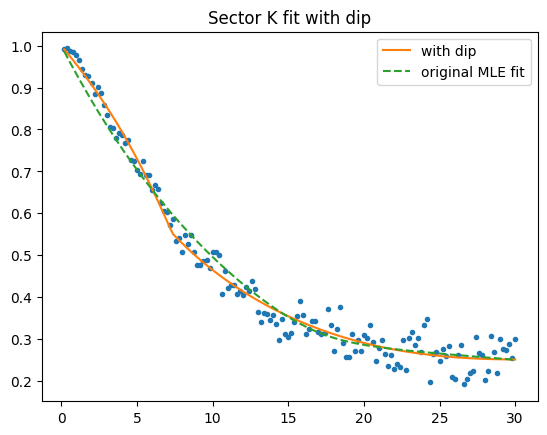

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector C
with dip: 79051.91207214272, original: 79121.45006331938
Parameters for sector C
mu_ub: 0.0902757782290526, mu_lb: 0.045052578472836544, K: 11.185024132238247, m: 4.968519448681556, t_e: 8.181253486576587, eps0: 0.29947880929652215, tau1: 1.7911875409142366, tau2: 1.350025426845829


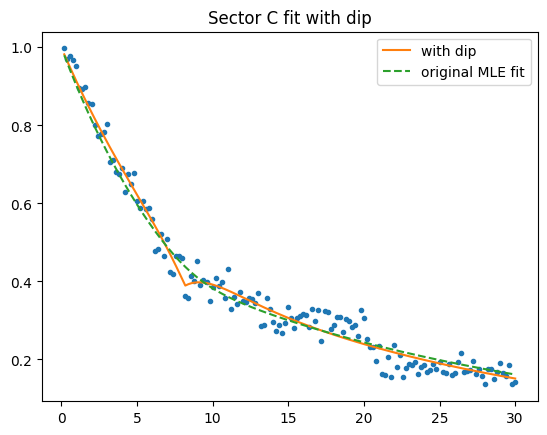

AIC for sector H
with dip: 83284.75408844059, original: 85957.7009922323
Parameters for sector H
mu_ub: 0.09184876149677991, mu_lb: 0.001, K: 22.19638706286954, m: 13.362377079933049, t_e: 7.152387648236043, eps0: 2.3133335939047655, tau1: 2.057930735606775, tau2: 0.8865449793807013


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


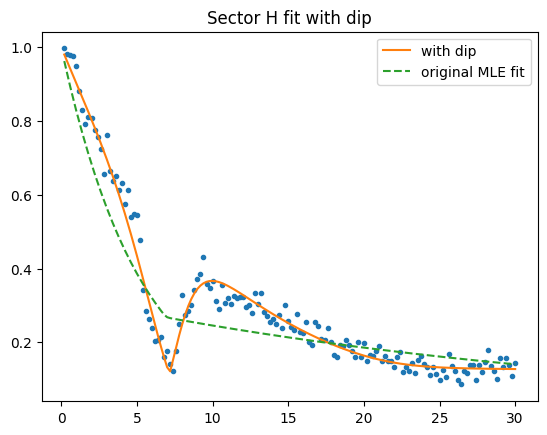

AIC for sector S
with dip: 71389.15910362975, original: 71512.5738700587
Parameters for sector S
mu_ub: 0.1345111210950949, mu_lb: 0.0037200332198503044, K: 13.429990690580926, m: 7.101217138483603, t_e: 8.214685065133667, eps0: 0.8189154466038024, tau1: 0.028324536186982212, tau2: 0.2466984861224107


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


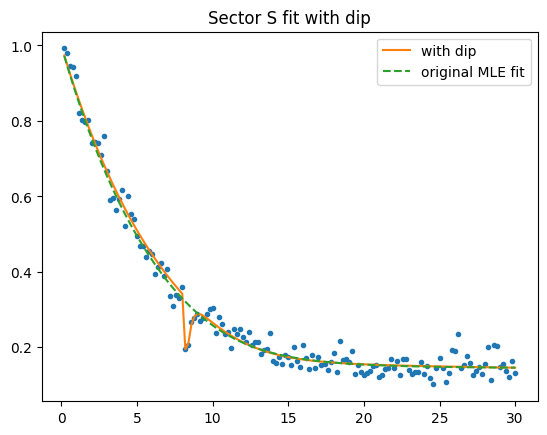

AIC for sector N
with dip: 73823.81677982573, original: 74032.64426437464
Parameters for sector N
mu_ub: 0.10571914912990867, mu_lb: 0.001, K: 19.661619954805623, m: 44.566293393853236, t_e: 8.399999994901057, eps0: 0.47492851118762264, tau1: 2.3476710855125957, tau2: 0.7964396905177986


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


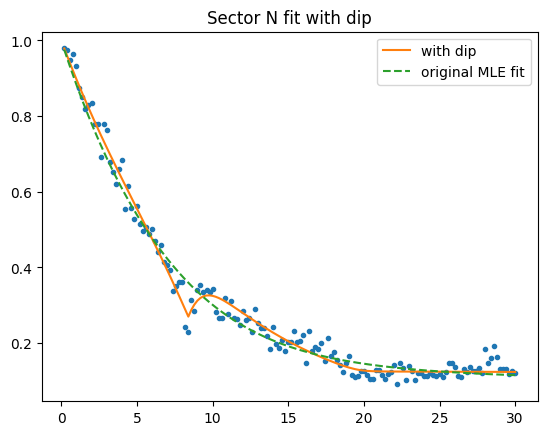

AIC for sector I
with dip: 68441.89243130808, original: 68509.00744804495
Parameters for sector I
mu_ub: 0.10577384731011244, mu_lb: 0.001, K: 23.483162130205653, m: 20.583151808016538, t_e: 7.215246009322951, eps0: 0.2962496103575598, tau1: 4.499481871061377, tau2: 7.813618529540557


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


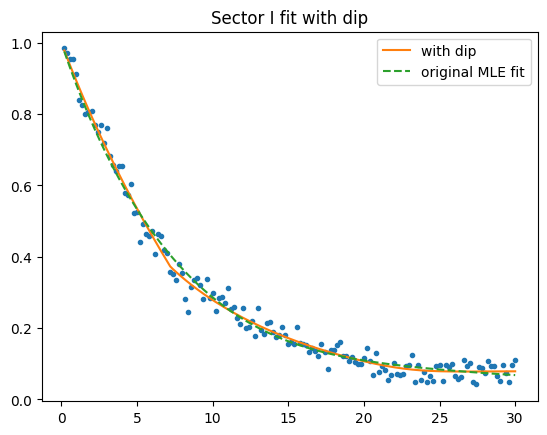

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector P
with dip: 50235.51996055439, original: 50319.80915016665
Parameters for sector P
mu_ub: 0.09098621464189476, mu_lb: 0.09073784615378648, K: 12.179685138703219, m: 5.810290329361915, t_e: 8.738531240659658, eps0: 0.5290422841338704, tau1: 4.9610904018086845, tau2: 3.4072685040688295


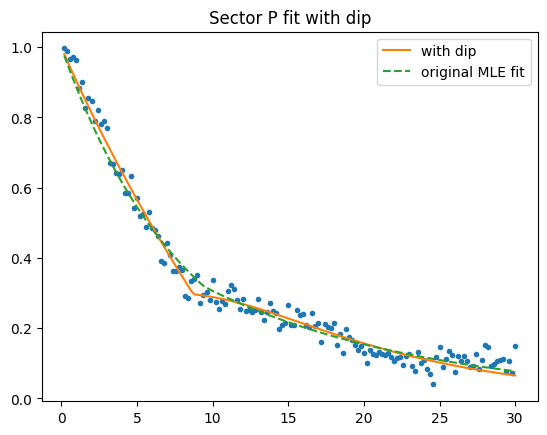

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector L
with dip: 24025.334410322557, original: 23846.6358313165
Parameters for sector L
mu_ub: 0.08610926365725607, mu_lb: 0.053637281541257374, K: 8.992813753351612, m: 4.542166145013363, t_e: 9.28784677194534, eps0: 0.4591640282911078, tau1: 0.6297642288724286, tau2: 0.27042101220762615


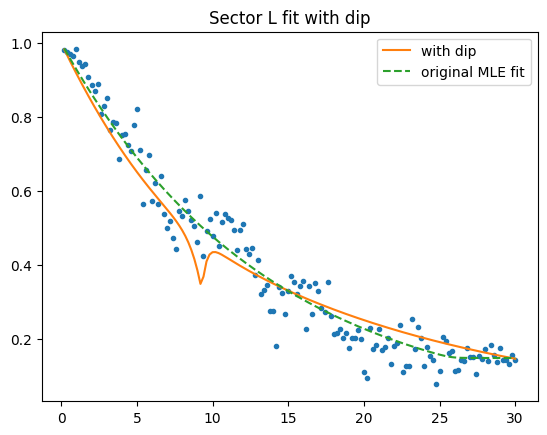

AIC for sector Q
with dip: 25769.021295382834, original: 25785.161680934158
Parameters for sector Q
mu_ub: 0.06831091937727665, mu_lb: 0.05080315937341551, K: 9.554806631090194, m: 5.265989287730379, t_e: 8.60003600565723, eps0: 0.3316666019566641, tau1: 3.6737708145226478, tau2: 0.4619510056081865


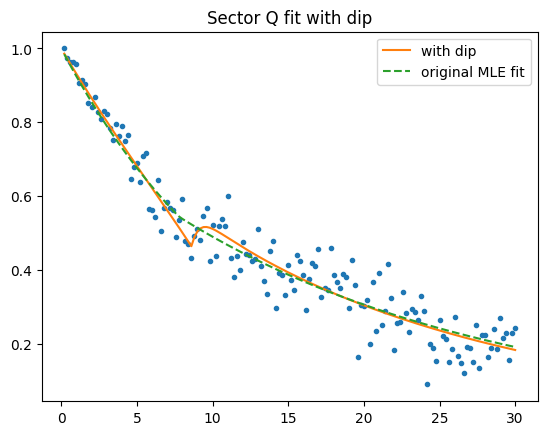

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


AIC for sector R
with dip: 15044.187738518904, original: 15047.29190362784
Parameters for sector R
mu_ub: 0.12076130402487868, mu_lb: 0.0940903669037532, K: 8.533953731552785, m: 7.2111698383569784, t_e: 4.176530388936875, eps0: 0.22575270721925655, tau1: 0.2780900602283565, tau2: 3.170661116482997


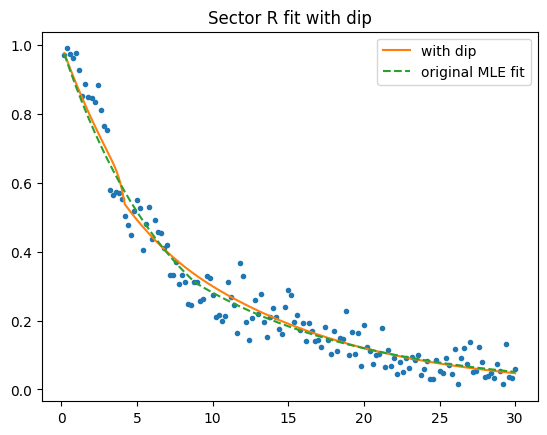

,G,M,F,J,K,C,H,S,N,I,P,L,Q,R
0,395459.535029,213426.427851,96641.344902,113753.375210,112040.011119,79051.912072,83284.754088,71389.159104,73823.816780,68441.892431,50235.519961,24025.334410,25769.021295,15044.187739
1,396775.653767,213844.852796,95543.987753,113998.288865,112433.754757,79121.450063,85957.700992,71512.573870,74032.644264,68509.007448,50319.809150,23846.635831,25785.161681,15047.291904


In [95]:
import pandas as pd
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]
sector_params_MLE = dict(zip(sector_list, parameters))
AIC_dict = {}

for sector in sector_list:
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess1, initial_guess2 = [0.1, 0.05, 10, 5, find_dip(sector), 0.5, 0.7, 0.3], [0.12, 0.01, 10, 5, find_dip(sector), 3.0, 2.0, 1.0]

    result1 = fit_hill_with_dip(ages, survivors, totals, initial_guess1)
    ll_1 = -neg_ll_hill_with_dip(result1.x, ages, survivors, totals)
    result2 = fit_hill_with_dip(ages, survivors, totals, initial_guess2)
    ll_2 = -neg_ll_hill_with_dip(result2.x, ages, survivors, totals)

    result = result1 if ll_1 > ll_2 else result2
    mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2 = result.x

    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    AIC_dict[sector] = (aic_with_dip, aic_original)
    print(f'AIC for sector {sector}')
    print(f'with dip: {aic_with_dip}, original: {aic_original}')
    print(f'Parameters for sector {sector}')
    print(f'mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau1: {tau1}, tau2: {tau2}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau1, tau2), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    # plt.plot(ages, model_survival_curve_hill(ages, mu_ub, mu_lb, K, m), label='without dip')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

(pd.DataFrame(AIC_dict)).head(8)